In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

### A linear mapping from input to output space

Linear regression assumes that some recorded output values $y_i$ for $i=1,...,N_\mathrm{samples}$ depend linearly on some input values $\mathbf{x}_i$, and that any deviations are due to noise. Given $\mathbf{x}$-$y$ data, your task is then to rediscover the form of this linear mapping, which in the simplest case corresponds to fitting a line to the data. The question is merely how to select the best line?

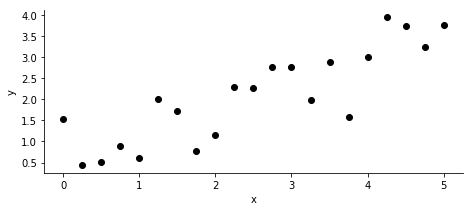

In [2]:
# Generate example data
# Initialize
sigma = 0.5                              # noise std
nSamples = 21                            # number of samples
x = np.linspace(0, 5, nSamples)          # input values
lineFun = lambda w0, w1, x: w0 + w1*x    # linear mapping

# Generate y-data
w0 = 1    # intercept
w1 = 0.5  # slope
y = lineFun(w0, w1, x)
y += np.random.randn(nSamples)*sigma

# Plot our generated data
plt.figure(figsize=(7.5, 3))
plt.plot(x, y, 'ko')
plt.xlabel('x')
plt.ylabel('y');

### Least squares approach

One approach for evaluating how good a line fits is by summing up the squared distances to each $y$-value from the line, and to compare this value for various lines. A lower value would indicate a better fit and a higher a worse fit. Usually, this sum is further divided by the number of samples, so as to get a mean squared error (MSE).

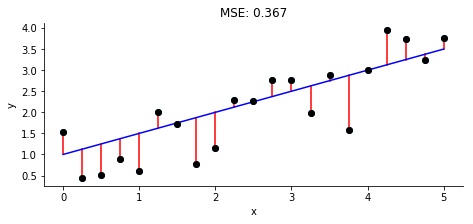

In [3]:
# Calculate the MSE for a test line
w0Test = 1.0
w1Test = 0.5
yHat = lineFun(w0Test, w1Test, x)              # Model predictions, the predicted line
mseFun = lambda y, yHat: np.mean((y-yHat)**2)  # MSE function
mseTest = mseFun(y, yHat)                      # MSE value for our test line

# Plot the test line (blue), the distace to each y_i (red) and the y-values (black)
plt.figure(figsize=(7.5, 3))
for xi, yi, yHati in zip(x, y, yHat): 
    plt.stem([xi], [yi], 'r', bottom=yHati)
plt.plot(x, yHat, 'b-')  
plt.plot(x, y, 'ko')
plt.xlabel('x')
plt.ylabel('y');
plt.title('MSE: ' + '%1.3f' % mseTest);

From the example above we learn that each line (a unique combination of $w_0$ and $w_1$) obtains a slightly different MSE value. Our task is therefore to find the $w_0$ and $w_1$ combination with the lowest value. Naively, we can try to do this by simply testing various combinations and plotting the MSE value as a function of both $w_0$ and $w_1$.

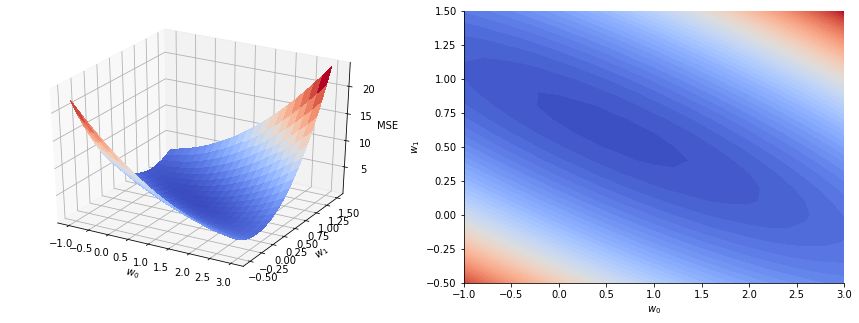

In [4]:
# Get w0 and w1 combinations over a grid
nGrid = 21
W0, W1 = np.meshgrid(np.linspace(w0-2, w0+2, nGrid), np.linspace(w1-1, w1+1, nGrid))

# Get the MSE for each combination
mseVals = np.zeros([nGrid, nGrid])
for i in range(nGrid):
    for j in range(nGrid):
        yHat = lineFun(W0[i, j], W1[i, j], x)
        mseVals[i, j] = mseFun(y, yHat)

# Plot the surface
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1, projection='3d')
ax.plot_surface(W0, W1, mseVals, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
ax.set_zlabel('MSE')
ax = plt.subplot(1, 2, 2)
ax.contourf(W0, W1, mseVals, 50, cmap=cm.coolwarm)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');

The take home message so far is thus that each line (unique combination of $w_0$ and $w_1$) corresponds to one point on a MSE surface, and that the best line in a MSE sense is at the bottom of the surface where the MSE minimum is located.

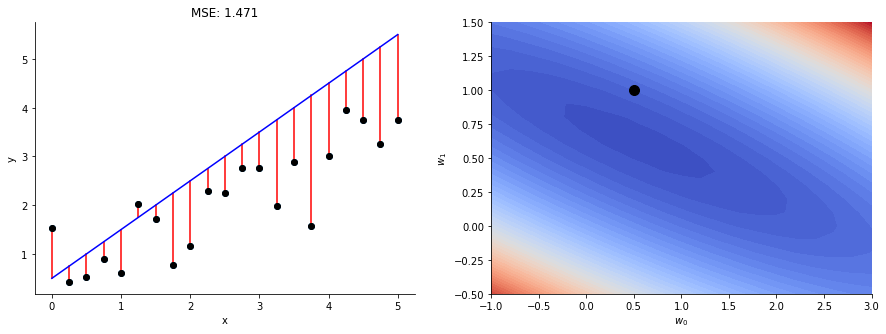

In [5]:
# Test various w0 and w1 values to see how the corresponding line fits at various locations on MSE surface
w0Test = 0.5
w1Test = 1.0

# Evaluate the MSE value for our current test line
yHat = lineFun(w0Test, w1Test, x)
mseFun = lambda y, yHat: np.mean((y-yHat)**2)
mseTest = mseFun(y, yHat)

# Plot
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
for xi, yi, yHati in zip(x, y, yHat): 
    ax.stem([xi], [yi], 'r', bottom=yHati)
ax.plot(x, yHat, 'b-')  
ax.plot(x, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('y');
ax.set_title('MSE: ' + '%1.3f' % mseTest);
ax = plt.subplot(1, 2, 2)
ax.contourf(W0, W1, mseVals, 50, cmap=cm.coolwarm)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
ax.plot(w0Test, w1Test, 'ko', ms=10);

###  How to find the minimum in practice

Before moving on we need a more general description of our optimization problem, and we obtain it by describing the linear mapping using matrix notation. The line equation used above ($\hat{y}_i = w_0+w_1 x_i$) can then be written as:

\begin{equation}
 \hat{y}_i = \mathbf{x}_i^T \mathbf{w}, \quad \text{where}: \mathbf{x}_i^T = [1, x_i] \; \text{and} \; \mathbf{w}^T = [w_0, w_1],
\end{equation}

and subsequently, it is possible to write the predictions for all samples as $\hat{\mathbf{y}} = \mathbf{X}\mathbf{w}$, where $\mathbf{x}_i^T$, ..., $\mathbf{x}_{N_\mathrm{samples}}^T$ make up the rows in $\mathbf{X}$. Similarly, the MSE can also be expressed with matrix notation as:

\begin{equation}
 MSE = \frac{1}{N_\mathrm{samples}} (\mathbf{y}-\mathbf{X}\mathbf{w})^T(\mathbf{y}-\mathbf{X}\mathbf{w})
\end{equation}

Now, lets assume that we start with an initial guess ($\tilde{w}$) for both $w_0$ and $w_1$, and then we will try to iteratively improve it. This does, however, require a way of choosing how to iteratively change $\tilde{w}$, but we can use the gradient for this. The gradient points in the direction that a function increases the fastest. So, by moving in the opposite direction we should effectively find new values for $w_0$ and $w_1$ that correspond to a lower MSE value. We this move on to find the gradient by differentiating the MSE function with respect to $\mathbf{w}$:

\begin{equation}
 \frac{MSE}{d\mathbf{w}} = \frac{-2}{N_\mathrm{samples}} \mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w})
\end{equation}

The idea of moving in the opposite direction to the gradient is fundamental to all gradient based optimization techniques, and the simplest idea of just taking small steps in the opposite direction is called gradient descent.

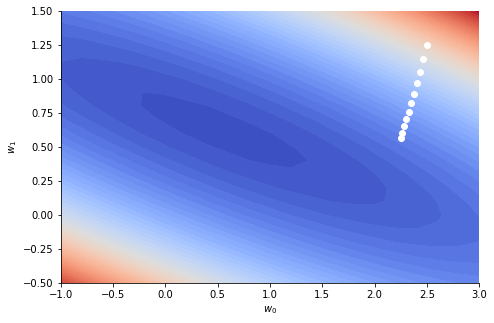

In [7]:
# Plot the MSE surface first
fig = plt.figure(figsize=(7.5, 5))
plt.contourf(W0, W1, mseVals, 50, cmap=cm.coolwarm)
plt.xlabel('$w_0$')
plt.ylabel('$w_1$');

# Gradient descent
eta = 0.5e-2                                 # step length
wTilde = np.array([2.5, 1.25])              # initial guess
X = np.vstack([np.ones(nSamples), x]).T     # create the X matrix where each row is one sample
plt.plot(wTilde[0], wTilde[1], 'o', ms=6, c=[1, 1, 1]) # Plot our initial location on the MSE surface
for i in range(10):
    gradient = -2./nSamples * np.dot(X.T, y-np.dot(X, wTilde))  # Calculate the gradient
    wTilde -= eta*gradient                                      # Move in the opposite direction of the gradient
    plt.plot(wTilde[0], wTilde[1], 'o', ms=6, c=[1, 1, 1])                 # Plot our new location on the MSE surface

Gradient descent is a stupidly simple approach, but it often converges quite slowly (as seen above). Luckily, we don't actually have to use it to find our MSE optimal line. We can actually take a shortcut by remembering that the gradient is zero at a the minimum. Thus, we can solve for the optimal $w_0$ and $w_1$ values by setting the gradient to zero:

\begin{align}
 \frac{-2}{N_\mathrm{samples}} \mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w}) &= 0 \\
 \mathbf{X}^T \mathbf{y} &= \mathbf{X}^T \mathbf{X}\mathbf{w}\\
 (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} &= \mathbf{w}
\end{align}

where the last line now corresponds to the classical expression for solving a linear regression problem.

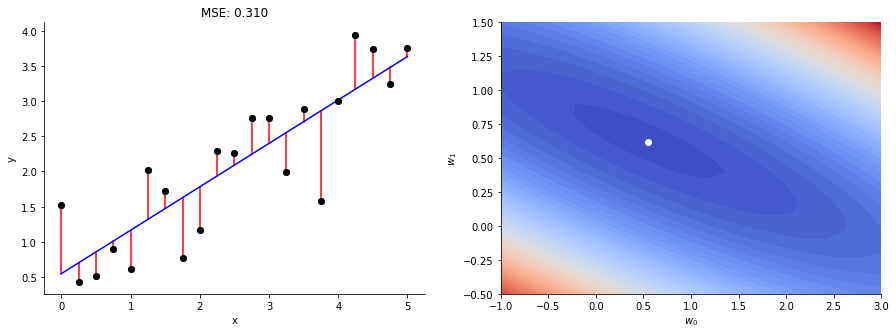

In [8]:
# Optimal solution
wOpt = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
yHat = lineFun(wOpt[0], wOpt[1], x)
mseFun = lambda y, yHat: np.mean((y-yHat)**2)
mseTest = mseFun(y, yHat)

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
for xi, yi, yHati in zip(x, y, yHat): 
    ax.stem([xi], [yi], 'r', bottom=yHati)
ax.plot(x, yHat, 'b-')  
ax.plot(x, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('y');
ax.set_title('MSE: ' + '%1.3f' % mseTest);
ax = plt.subplot(1, 2, 2)
ax.contourf(W0, W1, mseVals, 50, cmap=cm.coolwarm)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
ax.plot(wOpt[0], wOpt[1], 'o', ms=6, c=[1, 1, 1]);

### What if x is multi-dimensional?

The general solution derived above works even if $\mathbf{x}_i$ is multi-dimensional. The only difference is that we now try to fit a plane or a hyper-plane to the data instead of just a line.

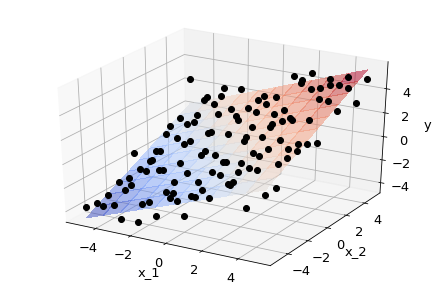

In [49]:
# Initialize
w0 = 0.5        # True parameter values for w0, w1, and w2
w1 = 0.5
w2 = 0.5
sigma = 1.      # noise std
nGrid = 11      # x-grid resolution
X1, X2 = np.meshgrid(np.linspace(-5, 5, nGrid), np.linspace(-5, 5, nGrid))    # x1 ans x2 values on a grid
planeFun = lambda w0, w1, w2, x1, x2: w0 + w1*x1 + w2*x2                      # linear mapping

# Generate noisy y-data
y = planeFun(w0, w1, w2, X1, X2).ravel()
y += np.random.randn(nGrid**2)*sigma

# Find the least squares solution
X = np.vstack([np.ones(nGrid**2), X1.ravel(), X2.ravel()]).T  
wOpt = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
yHat = planeFun(wOpt[0], wOpt[1], wOpt[2], X1, X2)

# Plot the found least squares plane and the data points
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X1.ravel(), X2.ravel(), y, 'ko')
ax.plot_surface(X1, X2, yHat, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y');

### Maximum likelihood, a second approach

Another approach of finding an optimal line would be to assume that each observed $y$-value consist of two parts, signal and noise, such that

\begin{equation}
 y_i = \mathbf{x}_i^T \mathbf{w} + \epsilon_i
\end{equation}

where $\epsilon$ is a normally distributed random noise term with zero mean. If the noise is identical and all data points (samples) are independent, then we can score various mappings (unique $\mathbf{w}$ vectors) by how likely it is that each particular mapping would have generated the observed data. That is, the probability to observe any one single data point for the mapping $\mathbf{w}$ is

\begin{equation}
 P(y_i|\mathbf{w}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(y_i - \mathbf{x}_i^T \mathbf{w})^2}{2 \sigma^2} \right),
\end{equation}

and subsequently, the likelihood for observing all independent data points are:

\begin{equation}
 l(\mathbf{y}|\mathbf{w}) = \prod_i^{N_\mathrm{samples}} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(y_i - \mathbf{x}_i^T \mathbf{w})^2}{2 \sigma^2} \right).
\end{equation}

It is however a bit cumbersome to work with likelihoods, but luckily we can work with the simpler log-likelihood instead. Taking logs of the likelihood thus gives:

\begin{align}
 ll(\mathbf{y}|\mathbf{w}) &= \sum_i^{N_\mathrm{samples}} \ -\frac{(y_i - \mathbf{x}_i^T \mathbf{w})^2}{2 \sigma^2} - N_\mathrm{samples} \log( \sqrt{2 \pi \sigma^2} ) \\
 ll(\mathbf{y}|\mathbf{w}) &= \frac{-1}{2 \sigma^2} (\mathbf{y}-\mathbf{X}\mathbf{w})^T(\mathbf{y}-\mathbf{X}\mathbf{w}) - N_\mathrm{samples} \log( \sqrt{2 \pi \sigma^2} ) 
\end{align}

The log-likelihood represents a function which we would like to maximize, in contrast to the MSE, as we want to find the $\mathbf{w}$ that is most likely to have generated the data. However, the gradient is zero at both a maximum and a minimum, and we can thus find the $\mathbf{w}$ at the maximum by setting the gradient of the log-likelihood function to zero.

\begin{align}
 \frac{ll(\mathbf{y}|\mathbf{w})}{d\mathbf{w}} = \frac{-1}{\sigma^2} \mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w}) = &0 \\
  \frac{-1}{\sigma^2} \mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w}) &= 0 \\
 \mathbf{X}^T \mathbf{y} &= \mathbf{X}^T \mathbf{X}\mathbf{w}\\
 (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} &= \mathbf{w}
\end{align}

Amazingly, we can now see that the maximum likelihood solution is the same as the least squares solution.

### Orthogonal projections, a third approach 

If we go back and look at how we described our linear mapping in matrix form

\begin{equation}
 \hat{\mathbf{y}} = \mathbf{X} \mathbf{w}
\end{equation}

we notice that all possible prediction vectors ($\hat{\mathbf{y}}$) live in the column space of $\mathbf{X}$, that is in the space spanned by the columns in $\mathbf{X}$. The intuitive explanation for this is that all prediction vectors are constructed as a linear combination of the columns in $\mathbf{X}$, and thus these must lie in the columns space of $\mathbf{X}$. This also means that if $\mathbf{y}$ is not in the column space of $\mathbf{X}$, then we can not describe it perfectly as a linear combination of the columns in $\mathbf{X}$. However, we can search for an orthogonal projection of $\mathbf{y}$ onto the column space, and this will represent the $\hat{\mathbf{y}}$ that is closest (euclidean norm) to $\mathbf{y}$, that is our best possible approximation. These ideas are illustrated below where the dashed black lines represent the columns of $\mathbf{X}$, the gray plane the column space, the blue line $\mathbf{y}$, the black line our orthogonal projection of $\mathbf{y}$, and the red line the error $\mathbf{y}-\hat{\mathbf{y}}$

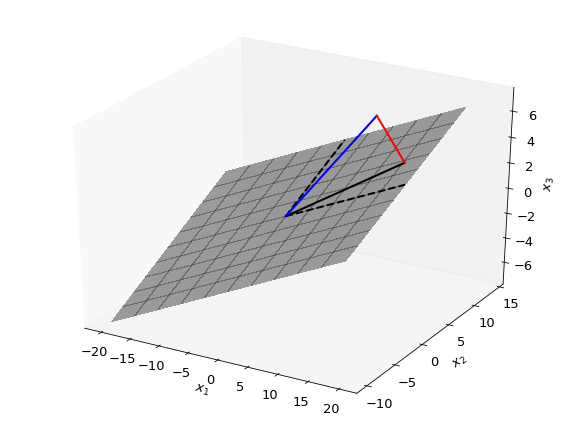

In [106]:
# Example X and y selected to get a descent figure
X = np.array([[1, 1, 1],[3, 1, 0.5]]).T
y = np.array([7, 14, 1])
wOpt = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
u = np.dot(X, wOpt)

# The columns space
nGrid = 11 
X1 = np.zeros([nGrid, nGrid])
X2 = np.zeros([nGrid, nGrid])
X3 = np.zeros([nGrid, nGrid])
W1, W2 = np.meshgrid(np.linspace(-5, 5, nGrid), np.linspace(-5, 5, nGrid))
for i in range(nGrid):
    for j in range(nGrid):
        X1[i, j] = W1[i, j]*X[0, 0] + W2[i, j]*X[0, 1]
        X2[i, j] = W1[i, j]*X[1, 0] + W2[i, j]*X[1, 1]
        X3[i, j] = W1[i, j]*X[2, 0] + W2[i, j]*X[2, 1]
        
# Plot columns vectors, the column space, y, and the orthogonal projection of y onto the column space 
fig = plt.figure(figsize=(10, 7.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, color='gray', linewidth=0, antialiased=False, alpha=0.5)
scaling = 5
ax.plot([0, scaling*X[0, 0]], [0, scaling*X[1, 0]], [0, scaling*X[2, 0]], 'k--', lw=2)
ax.plot([0, scaling*X[0, 1]], [0, scaling*X[1, 1]], [0, scaling*X[2, 1]], 'k--', lw=2)
ax.plot([0, y[0]], [0, y[1]], [0, y[2]], 'k-', lw=2)
ax.plot([0, u[0]], [0, u[1]], [0, u[2]], 'b-', lw=2)
ax.plot([y[0], u[0]], [y[1], u[1]], [y[2], u[2]], 'r-', lw=2)
ax.grid(False)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$');

The question is now then how to find the orthogonal projection of $\mathbf{y}$. We do, however, know that the inner product between two vectors is zero if they are orthogonal. The error $\mathbf{y}-\hat{\mathbf{y}}$ should thus be orthogonal to all columns in $\mathbf{X}$. If we now write this is mathematical terms, we get:

\begin{align}
 <\mathbf{X}, (\mathbf{y} - \hat{\mathbf{y}})> = <\mathbf{X}, (\mathbf{y} - \mathbf{X} \mathbf{w})> &= 0, \\
 \mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w}) &= 0, \\
 \mathbf{X}^T \mathbf{y} &= \mathbf{X}^T \mathbf{X}\mathbf{w}, \\
 (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} &= \mathbf{w},
\end{align}

and amazingly see that this approach also yielded the exact same solution as the original least squares approach.